## Binary Quantization

* 벡터의 각 차원을 1비트로 변환하여 메모리 절약
* 양수는 1, 음수는 0으로 변환하여 방향성만 유지
* 메모리 효율성과 처리 속도를 높이지만, 정확도가 떨어질 수 있음
* similarity search 진행 시, oversampling 후 re-ranking 하는 방식으로 보완 가능

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import time

f = h5py.File('openai_embedding_output.hdf5','r')
distances = f['distances']
neighbors = f['neighbors']
test = f['test']
train = f['train']

In [17]:
import numpy as np
from scipy.spatial.distance import hamming, cosine

class BinaryQuantization:
    def __init__(self, vectors):
        self.full_vectors = vectors
        self.vectors = self.binary_quantization(vectors)

    def binary_quantization(self, vectors):
        return np.where(vectors >= 0, 1, 0)

    def search(self, query, k):
        query_bin = self.binary_quantization(query)
        distances = np.array([hamming(query_bin, vec_bin) for vec_bin in self.vectors])
        closest_index = np.argsort(distances)[:k]

        return [(idx, distances[idx]) for idx in closest_index]

    def full_search(self, query, filtered_idx, k):

        distances = np.array([cosine(query, vec) for vec in self.full_vectors[filtered_idx]])
        closest_index = np.argsort(distances)[:k]

        return [(filtered_idx[idx], distances[idx]) for idx in closest_index]


In [19]:
bq = BinaryQuantization(train[:])

In [20]:
bq.search(test[0], 5)

[(199, 0.263671875),
 (270, 0.2734375),
 (520, 0.2786458333333333),
 (791, 0.28125),
 (498, 0.2916666666666667)]

In [21]:
[(n, d) for d, n in zip(distances[0][:5], neighbors[0][:5])]

[(791, 0.18023627996444702),
 (199, 0.18199849128723145),
 (270, 0.19761407375335693),
 (498, 0.20239192247390747),
 (320, 0.20566928386688232)]

In [22]:
## search speed and accuracy
accuracies_bq = []
times = []

for i in range(len(test)):
    start = time.time()
    search_result = bq.search(test[i], 5)
    times.append(time.time() - start)

    acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
    accuracies_bq.append(acc)

print(f"accuracy : {np.mean(accuracies_bq)}, qps : {1 / np.sum(times) * 100}")


accuracy : 0.682, qps : 77.70893461991524


In [23]:
## BQ만으로는 성능 부족 -> over-filtering 후 re-ranking 필요
qps_bq = []

## over-filtering
k = 20

for i in range(len(test)):
    search_result = bq.search(test[i], k)
    filtered_idx = np.array([idx for idx, _ in search_result])
    search_result = bq.full_search(test[i], filtered_idx, 5)
    acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
    accuracies_bq.append(acc)

print(f"accuracy : {np.mean(accuracies_bq)}")

accuracy : 0.8220000000000001


## Homework (내일까지 요구사항 및 skeleton/성능평가 코드 구체화 예정)
* IVF, HNSW에 binary quantization 적용 (index build/search)
* 정확도 저하 시 oversampling 및 re-ranking 적용
* 적용 이후 기존의 IVF, HNSW와 성능 비교 (recall, qps, 메모리 사용량 등)


In [24]:
from heapq import heapify, heappop, heappush, heapreplace, nlargest
from math import log2
from operator import itemgetter
from random import random
import numpy as np

class HNSWBQ(object):
    #### HNSW 코드를 적절히 변형

    def l2_distance(self, a, b):
        return np.linalg.norm(a - b)

    def cosine_distance(self, a, b):
        try:
            return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        except ValueError:
            print(a)
            print(b)

    def hamming_distance(self, a, b):

        # Count differing bits (Hamming distance) between two binary vectors
        return np.sum(a != b)

    def binary_quantize_vector(self, vec):
        return np.where(vec >= 0, 1, 0)

    def vectorized_distance_(self, x, ys):
        return [self.distance_func(x, y) for y in ys]

    def __init__(self, distance_type, M=5, efConstruction=200, Mmax=None, binary_quantize=False):
        if distance_type == "l2":
            distance_func = self.l2_distance
        elif distance_type == "cosine":
            distance_func = self.cosine_distance
        elif distance_type == "hamming" and binary_quantize:
            distance_func = self.hamming_distance
        else:
            raise TypeError('Please check your distance type!')

        self.distance_func = distance_func
        self.vectorized_distance = self.vectorized_distance_
        self._M = M
        self._efConstruction = efConstruction
        self._Mmax = 2 * M if Mmax is None else Mmax
        self._level_mult = 1 / log2(M)
        self._graphs = []
        self._enter_point = None
        self.data = []
        self.visit_count = 0
        self.binary_quantize = binary_quantize

    def binarize(self):
        self.binary_data = self.binary_quantize_vector(self.data)

    ### Algorithm 1: INSERT
    def insert(self, q, efConstruction=None):

        if efConstruction is None:
            efConstruction = self._efConstruction

        distance = self.distance_func
        data = self.data
        graphs = self._graphs
        ep = self._enter_point
        M = self._M

        # line 4: determine level for the new element q
        l = int(-log2(random()) * self._level_mult) + 1
        idx = len(data)
        data.append(q)

        if ep is not None:
            neg_dist = -distance(q, data[ep])

            # line 5-7: find the closest neighbor for levels above the insertion level
            for lc in reversed(graphs[l:]):
                neg_dist, ep = self._search_layer(q, [(neg_dist, ep)], lc, 1)[0]

            # line 8-17: insert q at the relevant levels; W is a candidate list
            layer0 = graphs[0]
            for lc in reversed(graphs[:l]):
                M_layer = M if lc is not layer0 else self._Mmax

                # line 9: update W with the closest nodes found in the graph
                W = self._search_layer(q, [(neg_dist, ep)], lc, efConstruction)

                # line 10: insert the best neighbors for q at this layer
                lc[idx] = layer_idx = {}
                self._select(layer_idx, W, M_layer, lc, heap=True)

                # line 11-13: insert bidirectional links to the new node
                for j, dist in layer_idx.items():
                    self._select(lc[j], (idx, dist), M_layer, lc)

        # line 18: create empty graphs for all new levels
        for _ in range(len(graphs), l):
            graphs.append({idx: {}})
            self._enter_point = idx

    ### Algorithm 5: K-NN-SEARCH
    def search(self, q, K=5, efSearch=20):
        """Find the K points closest to q."""

        distance = self.distance_func
        graphs = self._graphs
        ep = self._enter_point
        self.visit_count = 0

        if self.binary_quantize:
            data = self.binary_data
            q = self.binary_quantize_vector(q)

        if ep is None:
            raise ValueError("Empty graph")

        neg_dist = -distance(q, data[ep])

        # line 1-5: search from top layers down to the second level
        for lc in reversed(graphs[1:]):
            neg_dist, ep = self._search_layer(q, [(neg_dist, ep)], lc, 1)[0]

        # line 6: search with efSearch neighbors at the bottom level
        W = self._search_layer(q, [(neg_dist, ep)], graphs[0], efSearch)

        if K is not None:
            W = nlargest(K, W)
        else:
            W.sort(reverse=True)

        return [(idx, -md) for md, idx in W]

    ### Algorithm 2: SEARCH-LAYER
    def _search_layer(self, q, W, lc, ef):

        vectorized_distance = self.vectorized_distance
        data = self.data

        # Step 1: Initialize candidate list and visited set
        C = [(-neg_dist, idx) for neg_dist, idx in W]
        heapify(C)
        heapify(W)
        visited = set(idx for _, idx in W)

        # Step 4-17: Explore neighbors until candidate list is exhausted
        while C:
            dist, c = heappop(C)
            furthest = -W[0][0]
            if dist > furthest:
                break
            neighbors = [e for e in lc[c] if e not in visited]
            visited.update(neighbors)
            dists = vectorized_distance(q, [data[e] for e in neighbors])
            for e, dist in zip(neighbors, dists):
                self.visit_count += 1
                neg_dist = -dist
                if len(W) < ef:
                    heappush(C, (dist, e))
                    heappush(W, (neg_dist, e))
                    furthest = -W[0][0]
                elif dist < furthest:
                    heappush(C, (dist, e))
                    heapreplace(W, (neg_dist, e))
                    furthest = -W[0][0]

        return W

    ### Algorithm 3: SELECT-NEIGHBORS-SIMPLE
    def _select(self, R, C, M, lc, heap=False):

        if not heap:
            idx, dist = C
            if len(R) < M:
                R[idx] = dist
            else:
                max_idx, max_dist = max(R.items(), key=itemgetter(1))
                if dist < max_dist:
                    del R[max_idx]
                    R[idx] = dist
            return

        else:
            C = nlargest(M, C)
            R.update({idx: -neg_dist for neg_dist, idx in C})


In [25]:
hnswbq = HNSWBQ(distance_type="hamming", binary_quantize=True)


for i in range(len(train)):
    hnswbq.insert(train[i])


In [29]:
efs = [10, 20, 30, 40, 50, 100]
accuracies_hnsw = []
qps_hnsw = []

for ef in efs:

    query_acc = []
    query_per_second = []

    for i in range(len(test)):
        start = time.time()
        search_result = hnswbq.search(test[i], ef, ef)
        query_per_second.append(1 / (time.time() - start))

        acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
        query_acc.append(acc)

    qps_hnsw.append(np.mean(query_per_second))
    accuracies_hnsw.append(np.mean(query_acc))


for ef, acc, qp in zip(efs, accuracies_hnsw, qps_hnsw):
    print(f"ef : {ef}, accuracy : {acc}, qps : {qp}")


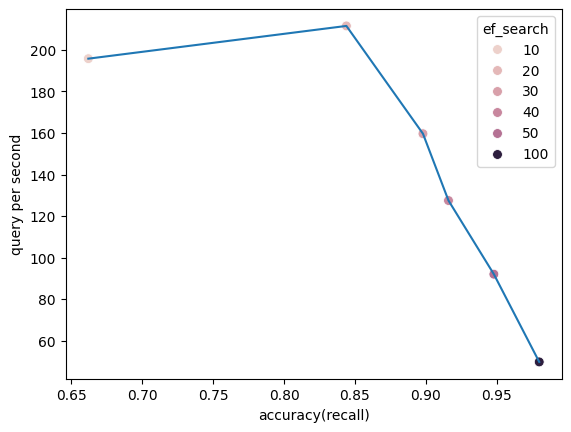

In [ ]:
sns.lineplot(x = accuracies_hnsw, y = qps_hnsw)
sns.scatterplot(x = accuracies_hnsw, y = qps_hnsw, hue = efs, s = 50)
plt.xlabel("accuracy(recall)")
plt.ylabel("query per second")
plt.legend(title = "ef_search")